<a href="https://colab.research.google.com/github/massimocipressi/MLPNS_MCipressi/blob/main/MPLNS_27_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [4]:
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams["image.interpolation"] = "nearest" #togliamo l'interpolazione automatica
plt.rcParams["image.cmap"] = "gist_gray" #useremo bianco e nero

In [8]:
cd /content/drive/MyDrive/MPLNS2023

/content/drive/MyDrive/MPLNS2023


In [9]:
ls

HiggsBoson/     spm-20210427T111354Z-001.zip  wine.data.1  wine.names.1
KaggleTitanic/  wine.data                     wine.names


In [10]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
  inflating: spm/spm_struct_pos.npy  
  inflating: spm/spm_struct_neg.npy  
  inflating: spm/test_good_all.npy   
  inflating: spm/train_good_all.npy  
  inflating: spm/test_bad_all.npy    
  inflating: spm/train_bad_all.npy   


In [12]:
data=np.load("spm/train_good_all.npy")

In [13]:
data.shape #sono 1302 immagini 64x64

(1302, 64, 64)

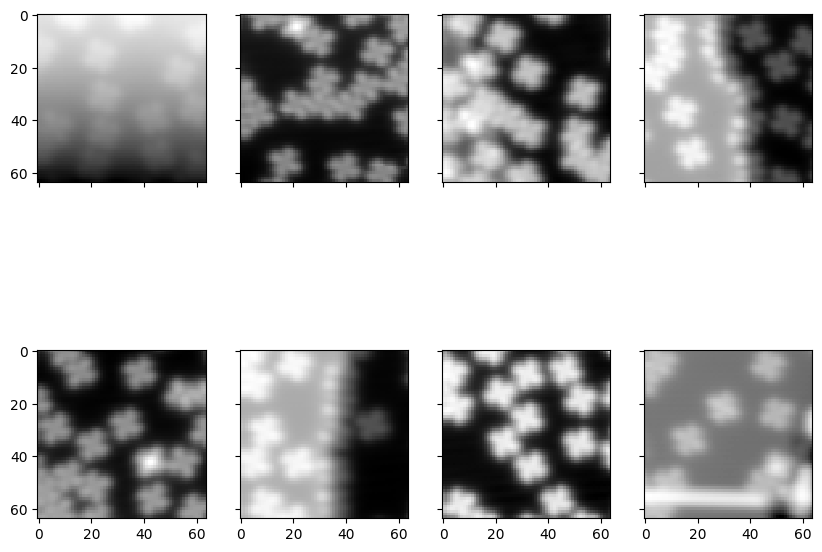

In [14]:
fig,ax=plt.subplots(2,4,sharex=True,sharey=True) #creo gli assi solo all'esterno
for ii in range(8):
  ax[ii//4,ii%4].imshow(data[ii]) #questo serve a selezionare gli indici giusti